# Best Practices
Julian Hsu

Simulated evidence for different ways to deal with various practical issues.

1. Outliers in $X_i$ and $Y_i$
2. Class imbalance in training propensity scores
3. Feature Selection
4. Bad control


In [1]:
import pandas as pd
import numpy as np
import os as os 

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.conditional_models import ConditionalLogit

from IPython.display import display    


import scipy.stats 

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error


In [2]:
import stnomics as st

In [3]:
## Write a function to write simulated data
def generate_data_skewed(te=100, skew_var=3):
    N = 1000
    x1 = np.random.lognormal(0,skew_var, N)
    x2 = np.random.lognormal(0,skew_var, N)

    treatment_latent = 10*(x2-0.5)**2 + 10*x1
    m,s = np.average(treatment_latent), np.std(treatment_latent)
    treatment_latent = (treatment_latent - m) / s
    
    random_t = np.random.normal(0,1,N)
    
    treatment_latent += random_t
    
    treatment = np.array( np.exp(treatment_latent) / (1+ np.exp(treatment_latent)) > np.random.uniform(0,1,N) ).astype(np.int32)

    Y = 100 +1.5*x1 + 6*x2
    random_y = np.random.uniform(0,10,N)

    GT = te
    Y += GT*(treatment==1) 
    
    df_est = pd.DataFrame({'x1':x1, 'x2':x2,'treatment':treatment, 'Y':Y, 'GT':GT} )
   
    return df_est

In [4]:
## Write a function to write simulated data
def generate_data(te=100):
    N = 1000
    x1 = np.random.normal(0,1, N)
    x2 = np.random.normal(0,1, N)

    treatment_latent = 10*(x2-0.5)**2 + 10*x1
    m,s = np.average(treatment_latent), np.std(treatment_latent)
    treatment_latent = (treatment_latent - m) / s
    
    random_t = np.random.normal(0,1,N)
    
    treatment_latent += random_t
    
    treatment = np.array( np.exp(treatment_latent) / (1+ np.exp(treatment_latent)) > np.random.uniform(0,1,N) ).astype(np.int32)

    Y = 100 +1.5*x1 + 6*x2

    random_y = np.random.uniform(0,10,N)

    GT = te
    Y += GT*(treatment==1) 
    
    df_est = pd.DataFrame({'x1':x1, 'x2':x2,'treatment':treatment, 'Y':Y, 'YError':random_y, 'TError':random_t, 'GT':GT} )
   
    return df_est

## 1. Outliers in $X_i$ and $Y_i$

We consider three different situations, and how they can influence the average treatment effect:
-  Outlier value in $Y_i$ due to an outlier value of $X_i$.
-  Outlier value in $Y_i$ due to an idiosyncratic error

### 1(a). Outlier value in $Y_i$ due to an outlier value of $X_i$.

In [5]:
## Outlier value in X resulting in an outlier value in Y
TrueEstimate = 50
df = generate_data_skewed(te=TrueEstimate, skew_var=3)
df.describe().T

outlier_row = pd.DataFrame(index=[2000,2001] , 
                                 data={'x1': [150, 350],
                                       'x2': [150, 350],'treatment': [1,0] } )

## Predict the outcome 
# rf_fit = LinearRegression().fit(df[['x1','x2']], df['Y'])
# outlier_row['Y'] = rf_fit.predict(outlier_row[['x1','x2']]) + outlier_row['treatment']*10
# outlier_row['treatment'] = np.ones(2)

In [6]:
# display(df.describe().T)
# display(outlier_row.describe().T)

,Y,x1,x2
count,1000.000000,1000.000000,1000.000000
mean,716.509645,58.449346,83.930938
std,5549.317416,660.785375,910.312522
min,100.032896,0.000475,0.000071
50%,157.885507,1.171774,1.030749
90%,545.526841,48.273541,52.457267
92.5%,724.460345,68.550796,70.859031
95%,1117.761468,105.162017,125.829887
97.5%,2695.670253,208.589143,351.776850
max,129846.232225,14162.060591,21615.574453


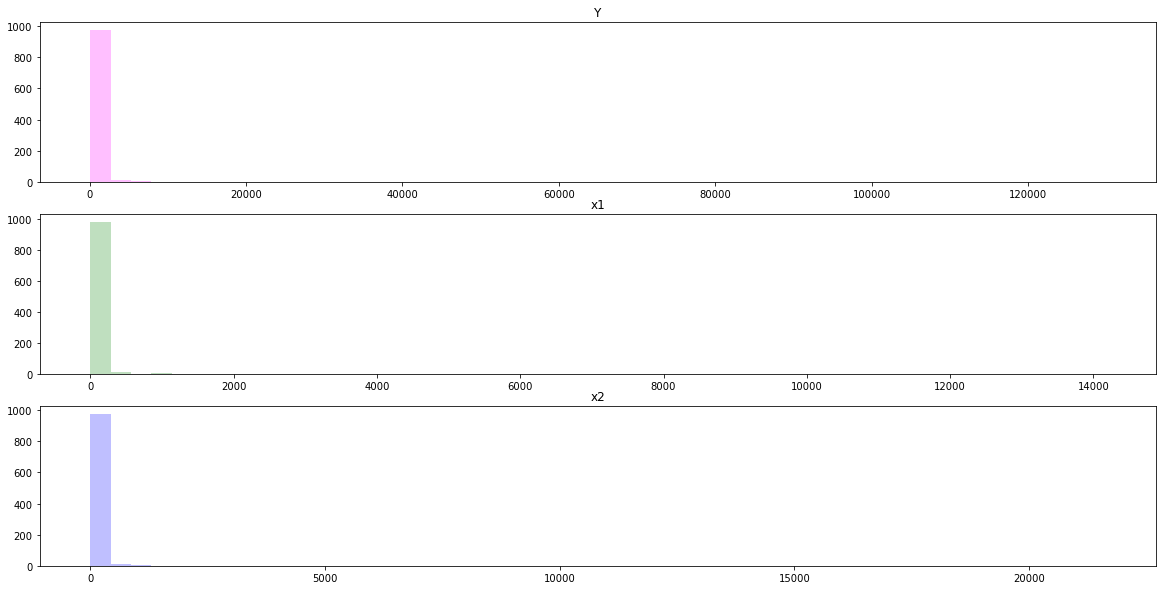

In [7]:
display(df[['Y','x1','x2']].describe(percentiles=np.arange(0.90,1,0.025))  )

fig,ax = plt.subplots(ncols=1,nrows=3, figsize=(20,10))
ax[0].hist(df['Y'], bins=50, density=False, alpha=0.25, color='magenta')
ax[0].set_title('Y')
ax[1].hist(df['x1'], bins=50, density=False, alpha=0.25, color='green')
ax[1].set_title('x1')
ax[2].hist(df['x2'], bins=50, density=False, alpha=0.25, color='blue')
ax[2].set_title('x2')
fig.set_facecolor('white')

In [8]:
feature_list = ['x1','x2']
outcome_name = 'Y'
treatment_name = 'treatment'
split_name= 'splits'
n_data_splits = 4
aux_dict = {'lower':0, 'upper':1}

In [9]:
print('Estimate without modification')
a = st.ate.dml.dml_plm(df, 
                split_name, feature_list, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)

print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
print('  True Value: {0:5.3f}'.format(TrueEstimate))

Estimate without modification
  16.451[147.876]
  True Value: 50.000


In [10]:
print('Estimate with logged independent features')

feature_list_log = []
for p in feature_list:
    df[p+'_log'] = np.log(1+df[p])
    feature_list_log.append(p+'_log')
    
a = st.ate.dml.dml_plm(df, 
                split_name, feature_list_log, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)

print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
print('  True Value: {0:5.3f}'.format(TrueEstimate))

Estimate with logged independent features
  20.342[149.099]
  True Value: 50.000


In [22]:
# fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(20,20))
# color_list = ['blue','orange','green','purple']
# ## Do this for different amounts of skewing
# skew_list = [1.0,1.75]
# diff_list = []
# te_list = []
# se_list = []
# for s, c__ in zip(skew_list, range(len(skew_list))) :
#     df = generate_data_skewed(te=TrueEstimate, skew_var=s)
#     a = st.ate.dml.dml_plm(df, 
#                     split_name, feature_list, outcome_name, treatment_name,
#                     RandomForestRegressor(n_estimators=200, random_state=27),
#                     RandomForestClassifier(n_estimators=200, random_state=27),
#                    n_data_splits,
#                    aux_dict)
#     ax.hist(df['x1'], density=True, bins=20, alpha=0.25, color=color_list[c__], label='{0:5.2f}'.format(a['ATE TE']))
# ax.set_ylabel('Density of X1')
# ax.set_xlabel('X1 values')
# fig.set_facecolor('white')
# ax.legend(loc='upper left')
    

In [48]:
## Do this for different amounts of skewing
skew_list = [1.0,2.00,2.50, 2.75, 2.80, 2.95, 3.00]
diff_list = []
te_list = []
se_list = []

bt_reps = 10
for s in skew_list:
    diff_bt_list = []
    te_bt_list = []
    for bt in range(bt_reps):
        df = generate_data_skewed(te=TrueEstimate, skew_var=s)
        ## Summarize amount of skew based on the number of standard deviations between the median and 95th percentile
        p50 = df['Y'].quantile(0.50)
        p95 = df['Y'].quantile(0.95)
        diff_sd = np.abs(p50 - p95) 

        a = st.ate.dml.dml_plm(df, 
                        split_name, feature_list, outcome_name, treatment_name,
                        RandomForestRegressor(n_estimators=50, random_state=27),
                        RandomForestClassifier(n_estimators=50, random_state=27),
                       n_data_splits,
                       aux_dict)
        diff_bt_list.append(diff_sd)
        te_bt_list.append(a['ATE TE'])
    diff_list.append(np.mean(diff_bt_list))
    te_list.append(np.mean(te_bt_list) )
    se_list.append(a['ATE SE'])

In [49]:
diff_sd = np.array(diff_sd) 
te_list = np.array(te_list)
se_list = np.array(se_list)

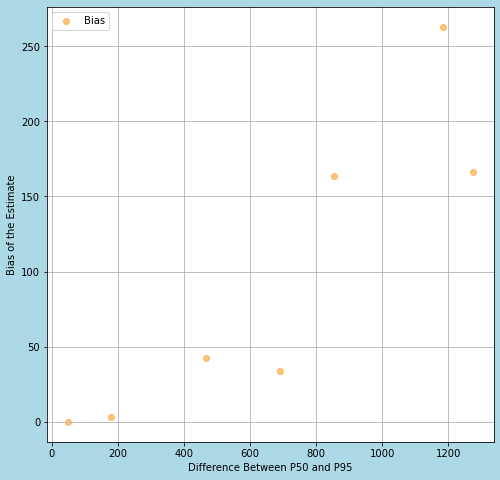

In [51]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))
ax.scatter(diff_list, te_list - TrueEstimate, color='darkorange', alpha=0.50, label='Bias')
# ax.vlines(diff_list, te_list+1.96*se_list- TrueEstimate, te_list-1.96*se_list- TrueEstimate, color='darkorange', label='95% CI')
ax.grid()
ax.set_xlabel('Difference Between P50 and P95')
ax.set_ylabel('Bias of the Estimate')
ax.legend(loc='upper left')
fig.set_facecolor('lightblue')

In [11]:
tp_value = 0.95
print('Estimate including indicators of feature values above {0}%'.format(tp_value*100))
feature_list_top95 = []
for p in feature_list:
    df[p+'_tp'] = (df[p]>=df[p].quantile(tp_value))
    feature_list_top95.append(p+'_tp')

feature_list_top95_X = []
for p in feature_list:
    df[p+'_tp_X'] = (df[p]>=df[p].quantile(tp_value))*df[p]
    feature_list_top95_X.append(p+'_tp_X')

a = st.ate.dml.dml_plm(df, 
                split_name, feature_list+feature_list_top95, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)   
print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
print('  True Value: {0:5.3f}'.format(TrueEstimate))


print('Estimate including indicators of feature values above {0}% and interactions with top {0}% values'.format(tp_value*100))
    
a = st.ate.dml.dml_plm(df, 
                split_name, feature_list+feature_list_top95+feature_list_top95_X, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)   
print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
print('  True Value: {0:5.3f}'.format(TrueEstimate))


print('Estimate including indicators of feature values above {0}% and logged features'.format(tp_value*100))
feature_list_top95_X_log = []
for p in feature_list:
    df[p+'_tp_X_log'] = (df[p]>=df[p].quantile(tp_value))*np.log(1+df[p])
    feature_list_top95_X_log.append(p+'_tp_X_log')

a = st.ate.dml.dml_plm(df, 
                split_name, feature_list_log+feature_list_top95, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)   
print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
print('  True Value: {0:5.3f}'.format(TrueEstimate))

print('Estimate including indicators of feature values above {0}% with logged features and interactions with top {0}%'.format(tp_value*100))
a = st.ate.dml.dml_plm(df, 
                split_name, feature_list_log+feature_list_top95+feature_list_top95_X_log, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)   
print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
print('  True Value: {0:5.3f}'.format(TrueEstimate))



Estimate including indicators of feature values above 95.0%
  333.766[360.346]
  True Value: 50.000
Estimate including indicators of feature values above 95.0% and interactions with top 95.0% values
  288.162[361.047]
  True Value: 50.000
Estimate including indicators of feature values above 95.0% and logged features
  328.213[358.607]
  True Value: 50.000
Estimate including indicators of feature values above 95.0% with logged features and interactions with top 95.0%
  262.311[358.995]
  True Value: 50.000


In [12]:
print('Estimate removing outlier outcome values of different values of removing the outcome')
pd.options.mode.chained_assignment = None  # default='warn'
outlier_percentile_cuts = np.round(np.arange(0.90,0.99, 0.005), 3)
est_list = []
se_list = []
pc_value_list = []
for p in outlier_percentile_cuts:
    pc = df['Y'].quantile(p)
    df_tp = df.loc[(df['Y'] < pc)]

    a = st.ate.dml.dml_plm(df_tp, 
                    split_name, feature_list_log+feature_list_top95+feature_list_top95_X, outcome_name, treatment_name,
                    RandomForestRegressor(n_estimators=200, random_state=27),
                    RandomForestClassifier(n_estimators=200, random_state=27),
                   n_data_splits,
                   aux_dict)   
    est_list.append(a['ATE TE'])
    se_list.append(a['ATE SE'])
    pc_value_list.append(pc)
#     print('  {0:5.3f}[{1:5.3f}]'.format(a[0], a[1]))
#     print('  True Value: {0:5.3f}'.format(TrueEstimate))


Estimate removing outlier outcome values of different values of removing the outcome


In [13]:
est_list = np.array(est_list)
se_list  = np.array(se_list)
pc_value_list = np.array(pc_value_list)

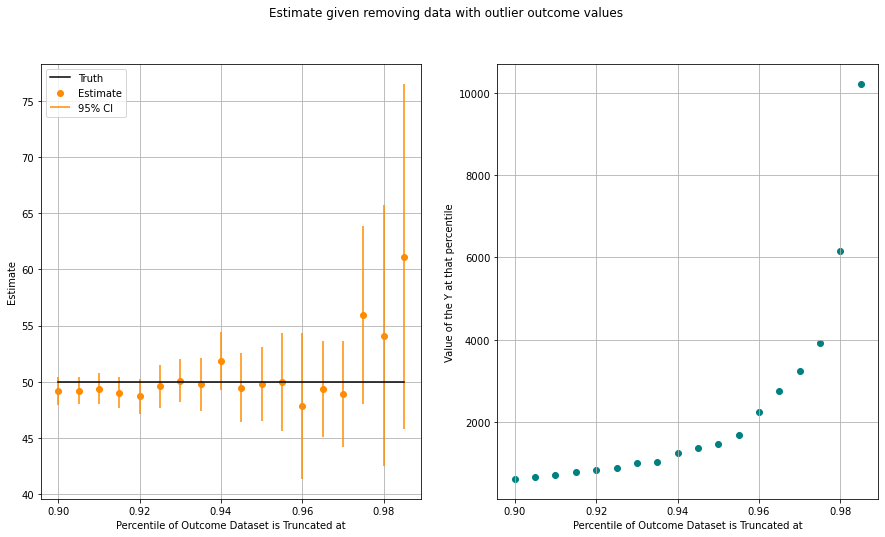

In [14]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(15,8))
ax[0].scatter(outlier_percentile_cuts, est_list , color='darkorange', label='Estimate' )
ax[0].vlines(outlier_percentile_cuts, est_list + 1.96*se_list, est_list - 1.96*se_list,  color='darkorange', label='95% CI' )
ax[0].plot(outlier_percentile_cuts, [50]*(len(outlier_percentile_cuts)) , color='black' , label='Truth')
ax[0].set_ylabel('Estimate')
ax[0].set_xlabel('Percentile of Outcome Dataset is Truncated at')
ax[0].legend(loc='upper left')
ax[0].grid()


ax[1].scatter(outlier_percentile_cuts, pc_value_list, color='teal')
ax[1].set_ylabel('Value of the Y at that percentile')
ax[1].set_xlabel('Percentile of Outcome Dataset is Truncated at')
ax[1].grid()
fig.suptitle('Estimate given removing data with outlier outcome values')
fig.set_facecolor('white')

In [15]:
print('Estimate winsorizing outlier outcome values')
pd.options.mode.chained_assignment = None  # default='warn'
outlier_percentile_cuts = np.round(np.arange(0.90,0.99, 0.005), 3)
est_list = []
se_list = []
pc_value_list = []
for p in outlier_percentile_cuts:
    pc = df['Y'].quantile(p)
    df['Y_tp'] = df['Y'].values
    df.loc[(df['Y_tp'] >= pc) ,'Y_tp'] = pc


    a = st.ate.dml.dml_plm(df, 
                    split_name, feature_list_log+feature_list_top95+feature_list_top95_X, 'Y_tp', treatment_name,
                    RandomForestRegressor(n_estimators=200, random_state=27),
                    RandomForestClassifier(n_estimators=200, random_state=27),
                   n_data_splits,
                   aux_dict)   
    est_list.append(a['ATE TE'])
    se_list.append(a['ATE SE'])
    pc_value_list.append(pc)



Estimate winsorizing outlier outcome values


In [16]:
est_list = np.array(est_list)
se_list  = np.array(se_list)
pc_value_list = np.array(pc_value_list)

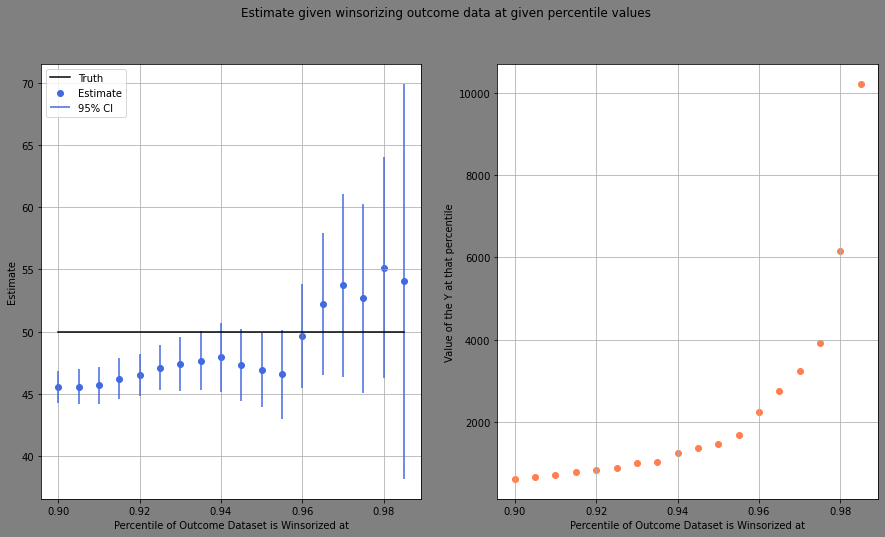

In [17]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(15,8))
ax[0].scatter(outlier_percentile_cuts, est_list , color='royalblue', label='Estimate' )
ax[0].vlines(outlier_percentile_cuts, est_list + 1.96*se_list, est_list - 1.96*se_list,  color='royalblue', label='95% CI' )
ax[0].plot(outlier_percentile_cuts, [50]*(len(outlier_percentile_cuts)) , color='black' , label='Truth')
ax[0].set_ylabel('Estimate')
ax[0].set_xlabel('Percentile of Outcome Dataset is Winsorized at')
ax[0].legend(loc='upper left')
ax[0].grid()


ax[1].scatter(outlier_percentile_cuts, pc_value_list, color='coral')
ax[1].set_ylabel('Value of the Y at that percentile')
ax[1].set_xlabel('Percentile of Outcome Dataset is Winsorized at')
ax[1].grid()
fig.suptitle('Estimate given winsorizing outcome data at given percentile values')
fig.set_facecolor('grey')

In [19]:
print('Estimate winsorizing outlier outcome values')
df['Y_tp'] = df['Y'].values
df.loc[(df['Y_tp'] >= df['Y_tp'].quantile(0.98)),'Y_tp'] = df['Y'].quantile(0.98)

a = st.ate.dml.dml_plm(df, 
                split_name, feature_list_log+feature_list_top95+feature_list_top95_X, 'Y_tp', treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)  
print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
print('  True Value: {0:5.3f}'.format(TrueEstimate))

Estimate winsorizing outlier outcome values
  55.146[4.530]
  True Value: 50.000


### What about a quantile regression approach?

In [90]:
def quant_reg(data,f, y, qcut=0.50):
    X = sm.add_constant(data[f])    
    quant = sm.regression.quantile_regression.QuantReg(data[y], X ).fit(q=qcut)
    return quant.params[-1],quant.bse[-1] 

def quant_dml_reg(y_res, t_res, qcut=0.50):
    quant = sm.regression.quantile_regression.QuantReg( y_res, t_res ).fit(q=qcut)
    return quant.params[-1],quant.bse[-1] 


In [62]:
X = sm.add_constant(df[['x1','x2', 'treatment']] )
quant = sm.regression.quantile_regression.QuantReg(df['Y'], X ).fit(q=0.25)
display(quant.summary())

## Create some additional noise in the data
df.loc[(df['treatment']==1), 'Y'] += np.random.uniform(0,1, (df['treatment']==1).sum() )
quant = sm.regression.quantile_regression.QuantReg(df['Y'], X ).fit(q=0.25)
display(quant.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                      Y   Pseudo R-squared:               0.6468
Model:                       QuantReg   Bandwidth:                      0.1141
Method:                 Least Squares   Sparsity:                       0.2866
Date:                Mon, 27 Dec 2021   No. Observations:                 1000
Time:                        21:36:01   Df Residuals:                      996
                                        Df Model:                            3
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.0000      0.009   1.09e+04      0.000      99.982     100.018
x1             1.5000      0.005    274.782      0.000       1.489       1.511
x2             6.0000      0.005   1202.398      0.000       5.990       6.010
treatment     50.2801      0.011   4568.482      0.000      50.259      50.302
==============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                      Y   Pseudo R-squared:               0.6471
Model:                       QuantReg   Bandwidth:                      0.1411
Method:                 Least Squares   Sparsity:                       0.3665
Date:                Mon, 27 Dec 2021   No. Observations:                 1000
Time:                        21:36:01   Df Residuals:                      996
                                        Df Model:                            3
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.0000      0.010   1.01e+04      0.000      99.981     100.019
x1             1.5000      0.006    263.629      0.000       1.489       1.511
x2             6.0000      0.006   1043.296      0.000       5.989       6.011
treatment     50.7400      0.013   3880.171      0.000      50.714      50.766
==============================================================================
"""

In [133]:
## Now we generate some heterogeneous treatment effects.
# df = generate_data_skewed(te=np.random.normal(10,1, 1000))


est_dict = {'0.25':[], '0.50':[], '0.75':[],}
se_dict = {'0.25':[], '0.50':[], '0.75':[],}

sim_range = range(20)
for r in sim_range:
    df = generate_data_skewed(te=np.random.uniform(0,100, 1000))
    for r in list( est_dict.keys() ):
        a = quant_reg(df,['x1','x2', 'treatment'], 'Y', qcut=float(r) ) 
#         print('Estimate on {0} quantile:  {1:5.3f}[{2:5.3f}]'.format(r, a[0],a[1]))
        est_dict[str(r)].append(a[0])
        se_dict[str(r)].append(a[1])


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


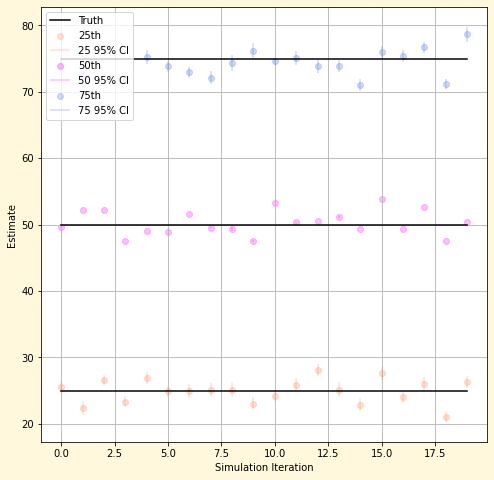

In [137]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))

for r, c in zip( list( est_dict.keys()), ['coral','magenta','royalblue'] ):
    est_dict[r] = np.array(est_dict[r])
    se_dict[r] = np.array(se_dict[r])    
    r_p = r[-2:]
    ax.scatter(sim_range , est_dict[r], color=c, alpha=0.25, label=r_p+'th')
    ax.vlines(sim_range , est_dict[r] + 1.96*se_dict[r],est_dict[r] - 1.96*se_dict[r], color=c, alpha=0.25, label=r_p+' 95% CI')    
ax.plot(sim_range, [25]*len(sim_range), color='black', label='Truth')
ax.plot(sim_range, [50]*len(sim_range), color='black')
ax.plot(sim_range, [75]*len(sim_range), color='black')
ax.set_xlabel('Simulation Iteration')
ax.set_ylabel('Estimate')
ax.grid()
ax.legend(loc='upper left')
fig.set_facecolor('cornsilk')

In [168]:
# '''
# What if we try a DML-style approach? A little suspicious because residualization is about the average, not the median.
# '''
# from sklearn.linear_model import QuantileRegressor

# from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# st.block_splits(df, split_name='splits', n_data_splits=4)
# treatment_out = st.predict_treatment_indicator(df, 'splits', 4, ['x1','x2'], 'treatment', 
#                                                GradientBoostingClassifier(n_estimators=200, random_state=27,criterion="mae"))   
# y_out = st.predict_continuous(df, 'splits', 4, ['x1','x2'], 'treatment', 
#                               GradientBoostingRegressor(n_estimators=200, random_state=27,loss="quantile", alpha=0.50))   

# for r in np.round( np.arange(0.10, 1, 0.1), 3 ):
#     a = quant_dml_reg(y_out, treatment_out, qcut=r)
#     print('Estimate on {0:3.2f} quantile:  {1:5.3f}[{2:5.3f}]'.format(r, a[0],a[1]))

    


### 1(b). Outlier value in $Y_i$ due to idiosyncractic error

In [20]:
df = generate_data(te=50)
## For a random 10% of the sample, increase the outcome by a random number
random10 = int( len(df) / 10 )
print('Before large idiosyncratic errors')
display(df['Y'].describe())
df[0:random10]['Y'] += np.random.normal(100,1, random10)
print('After large idiosyncratic errors')
display(df['Y'].describe())

Before large idiosyncratic errors


count    1000.000000
mean      124.808317
std        25.097777
min        83.241013
25%       100.726356
50%       115.104895
75%       148.918031
max       174.222204
Name: Y, dtype: float64

After large idiosyncratic errors


count    1000.000000
mean      134.797144
std        38.550907
min        83.241013
25%       101.548002
50%       140.543397
75%       152.253327
max       263.258934
Name: Y, dtype: float64

In [21]:
print('Estimate without modification')
a = st.ate.dml.dml_plm(df, 
                split_name, feature_list, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)

print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
print('  True Value: {0:5.3f}'.format(TrueEstimate))

Estimate without modification
  45.631[2.247]
  True Value: 50.000


In [22]:
## Do this over many repetitions
te_outlier_list = []
se_outlier_list = []

te_list = []
se_list = []

sim_number = 50
for r in range(sim_number):
    df = generate_data(te=50)
    ## Estimate without any outliers
    a = st.ate.dml.dml_plm(df, 
                split_name, feature_list, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)
    te_list.append(a['ATE TE'])
    se_list.append(a['ATE SE'])
    
    ## For a random 10% of the sample, increase the outcome by a random number
    random10 = int( len(df) / 10 )

    df[0:random10]['Y'] += np.random.normal(150,1, random10)
    a = st.ate.dml.dml_plm(df, 
                split_name, feature_list, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)
    te_outlier_list.append(a['ATE TE'])
    se_outlier_list.append(a['ATE SE'])


In [23]:
te_outlier_list = np.array(te_outlier_list)
se_outlier_list = np.array(se_outlier_list)

te_list = np.array(te_list)
se_list = np.array(se_list)

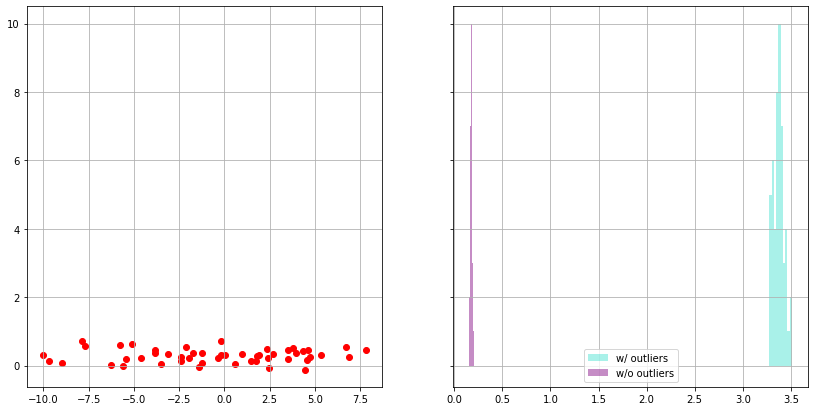

In [37]:
fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(14,7), sharey=True)
ax[0].scatter(te_outlier_list-50, te_list-50, color='red')
ax[0].grid()

ax[1].hist(se_outlier_list, color='turquoise', alpha=0.45, label='w/ outliers')
ax[1].hist(se_list, color='purple', alpha=0.45, label='w/o outliers')
ax[1].grid()
ax[1].legend()

fig.set_facecolor('white')

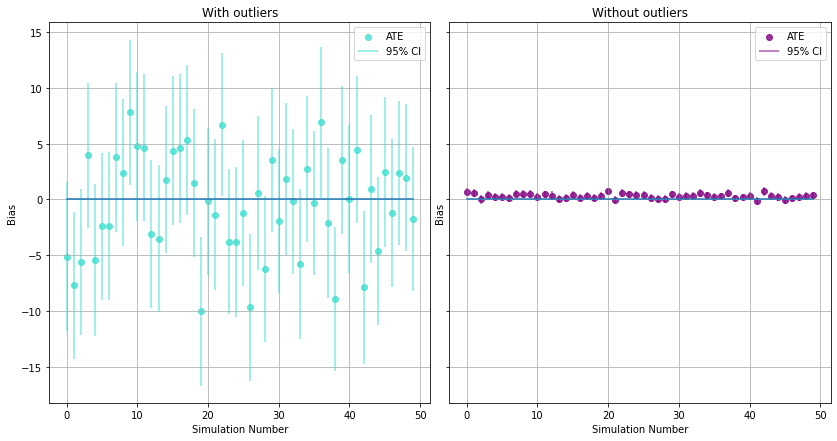

In [41]:
fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(14,7), sharey=True)
ax[0].scatter(range(sim_number), te_outlier_list-50, alpha=0.8, color='turquoise', label='ATE')
ax[0].vlines(range(sim_number), te_outlier_list+1.96*se_outlier_list-50, te_outlier_list-1.96*se_outlier_list-50, alpha=0.65, color='turquoise', label='95% CI')
ax[0].plot(range(sim_number), np.zeros(sim_number))
ax[0].set_ylabel('Bias')
ax[0].set_xlabel('Simulation Number')
ax[0].legend()
ax[0].grid()
ax[0].set_title('With outliers')

ax[1].scatter(range(sim_number), te_list-50, alpha=0.8, color='purple', label='ATE')
ax[1].vlines(range(sim_number), te_list+1.96*se_list-50, te_list-1.96*se_list-50, alpha=0.65, color='purple', label='95% CI')
ax[1].plot(range(sim_number), np.zeros(sim_number))
ax[1].set_ylabel('Bias')
ax[1].set_xlabel('Simulation Number')
ax[1].legend()
ax[1].grid()
ax[1].set_title('Without outliers')
plt.subplots_adjust(wspace=0.05, hspace=0)
fig.set_facecolor('white')

In [169]:
print(np.average(te_list))
print(np.average(te_outlier_list))

15208.20087862986
49.52552202694366


## 2. Class imbalance in training propensity scores
## 3. Feature Selection



In [170]:
## Write a function to write simulated data
def generate_data_select(te=100, num_features = 10):
    N = 1000
    
    features = {}
    features['Y'] = np.random.normal(0,1, len(df))
    
    ## Create relevant features
    for n in range(num_features):
        features['x'+str(n)] = np.random.normal(0,1,N)
        if n > num_features / 2:
            features['Y'] += features['x'+str(n)]*np.random.uniform(-5,5)
        else:
            pass
    ## Assign a treatment conditional on the relevant features
    latent_treatment = np.zeros(N)
    for n in range(num_features):
        latent_treatment += features['x'+str(n)]*np.random.uniform(-1,1)
    latent_treatment += np.random.normal(0,1,N)
    latent_treatment = (np.average(latent_treatment) - latent_treatment) / np.std(latent_treatment)
    
    features['W'] = ( latent_treatment > 0 ).astype(float)
    features['Y'] += features['W']*te
    
    ## Assign some orthogonal features
    for n in range(num_features):
        features['x_xx'+str(n)] = np.random.normal(0,1,N)    
    
    df_est = pd.DataFrame(features )
   
    return df_est

In [171]:
def ols_stat(data,f, y):
    X = sm.add_constant(data[f])
    ols = sm.OLS( data[y] , X ).fit()
    return ols.params['W'],ols.bse['W'] 

from sklearn.linear_model import LassoCV
def lasso_stat(data,f, y):
    lss = LassoCV(random_state=27).fit(  data[f], data[y]  )
    return lss.coef_[-1]

In [172]:
TrueEstimate = 0.5
sim_num_features = 100

sim_iter = 100
sim_ols_estimate = []
sim_lss_estimate = []

for r in range(sim_iter):
    df = generate_data_select(te=TrueEstimate, num_features=sim_num_features)

    a = ols_stat(df, [x for x in df.columns if 'x' in x] + ['W'], 'Y')
    sim_ols_estimate.append(a[0]-TrueEstimate)
    b = lasso_stat(df, [x for x in df.columns if 'x' in x] + ['W'], 'Y')
    sim_lss_estimate.append(b - TrueEstimate)

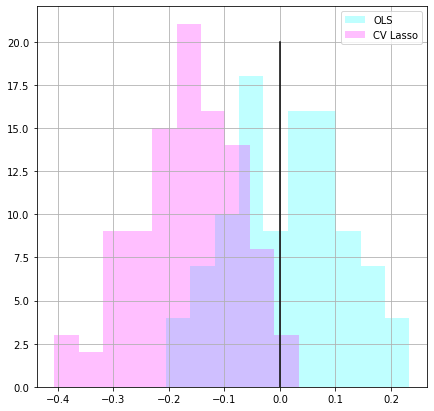

In [173]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
ax.hist(sim_ols_estimate, density=False, alpha=0.25, color='aqua', label='OLS')
ax.hist(sim_lss_estimate, density=False, alpha=0.25, color='magenta', label='CV Lasso')
ax.plot([0,0], [0,20], color='black')
ax.legend()
ax.grid()
fig.set_facecolor('white')

In [174]:
print(  np.average(sim_ols_estimate)  )
print(  np.average(sim_lss_estimate)  )

0.015062728056189318
-0.1660791262548395


In [175]:
### What about cross-validated feature selection?
## Do the same simulations again.

In [176]:
TrueEstimate = 0.5
sim_num_features = 100

sim_iter = 100
sim_ols_estimate = []
sim_lss_estimate = []
sim_hdm_estimate = []

for r in range(sim_iter):
    df = generate_data_select(te=TrueEstimate, num_features=sim_num_features)

    a = ols_stat(df, [x for x in df.columns if 'x' in x] + ['W'], 'Y')
    sim_ols_estimate.append(a[0]-TrueEstimate)
    b = lasso_stat(df, [x for x in df.columns if 'x' in x] + ['W'], 'Y')
    sim_lss_estimate.append(b - TrueEstimate)
        
    hdm_output = st.diagnostics.selection.hdm_selection(df, 
                                [x for x in df.columns if 'x' in x], 'Y', 'W')
    hdm_selected_features=list(set(hdm_output[0][0]+hdm_output[0][1]))
    a = ols_stat(df, hdm_selected_features + ['W'], 'Y')
    sim_hdm_estimate.append(a[0]-TrueEstimate)    

KeyboardInterrupt: 

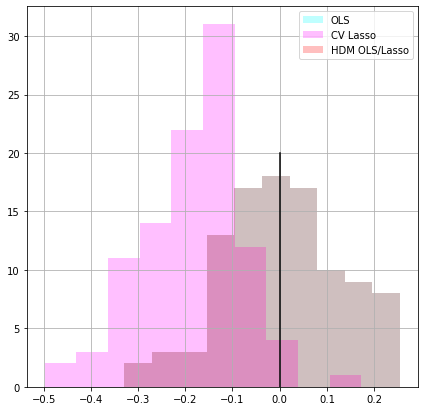

In [115]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
ax.hist(sim_ols_estimate, density=False, alpha=0.25, color='aqua', label='OLS')
ax.hist(sim_lss_estimate, density=False, alpha=0.25, color='magenta', label='CV Lasso')
ax.hist(sim_hdm_estimate, density=False, alpha=0.25, color='red', label='HDM OLS/Lasso')
ax.plot([0,0], [0,20], color='black')
ax.legend()
ax.grid()
fig.set_facecolor('white')

## 4. Bad control
1. Control for an intermediate outcome that also influences the final outcome
2. Control for another outcome 

In [78]:
'''
1. Control for intermediate outcome
'''
## Create other outcomes
TrueEstimate = 50
df = generate_data(te=TrueEstimate)

## Create a second outcome that depends on similar features as 'Y'
## Suppose this second outcome is the longer-term outcome of interest
df['R1'] = ( 2*np.sin(df['x1']) + df['treatment'] + np.random.normal(0,1,len(df)) ) > 0
print(pd.crosstab(df['R1'], df['treatment']))
df['Y_2nd'] = df['Y'] + TrueEstimate * df['R1'] 



print('Correct Specification')
a = st.ate.dml.dml_plm(df, 
                split_name, feature_list , 'Y_2nd', treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)
print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
# print('  True Value: {0:5.3f}'.format(TrueEstimate))


print('Control for intermediate outcome')
a = st.ate.dml.dml_plm(df, 
                split_name, feature_list + ['R1'] , 'Y_2nd', treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)
print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
# print('  True Value: {0:5.3f}'.format(TrueEstimate))


treatment    0    1
R1                 
False      264  131
True       223  382
Correct Specification
  60.840[1.202]
Control for intermediate outcome
  50.406[0.196]


In [32]:
# '''
# 1. Control for another outcome
# '''

# x = np.random.uniform(0,1, 1000)
# e = np.random.normal(0,1, 1000)
# u = np.random.normal(0,1, 1000)

# y = x + e
# s1 = x**2 + np.sin(x) + u
# s2 = x**2 + x + e + u

# df = pd.DataFrame(data={'x':x,'y':y,'e':e,'u':u,'s1':s1,'s2':s2})

# X = sm.add_constant(df['x'])
# ols = sm.OLS( df['y'] , X ).fit()
# print('Correct Result:')
# print(' {0:5.3f}  [{1:5.3}]'.format(ols.params['x'], ols.bse['x']))

# X = sm.add_constant(df[['x','e']])
# ols = sm.OLS( df['y'] , X ).fit()
# print('Wrong Result control for a highly correlated outcome:')
# print(' {0:5.3f}  [{1:5.3}]'.format(ols.params['x'], ols.bse['x']))

# X = sm.add_constant(df[['x','e','u']])
# ols = sm.OLS( df['y'] , X ).fit()
# print('Wrong Result control for a co-determined outcome:')
# print(' {0:5.3f}  [{1:5.3}]'.format(ols.params['x'], ols.bse['x']))


In [79]:
## Create other outcomes
TrueEstimate = 50
df = generate_data(te=TrueEstimate)

## Outcome is independent
df['S_0'] = 0.25*df['x1'] - 0.15*df['x2'] + np.random.normal(0,1,len(df))

## Outcome is highly correlated with error in Y
df['S_1'] = df['YError']  + np.random.normal(0,1,len(df))

## Outcome is basically Y
df['S_2'] = df['Y'] + np.random.normal(0,1,len(df))

## Outcome is highly correlated with error in T
df['S_3'] = df['TError'] + np.random.normal(0,1,len(df))


In [82]:

print('Correct Specification')
a = st.ate.dml.dml_plm(df, 
                split_name, feature_list , outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)
print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
print('  True Value: {0:5.3f}'.format(TrueEstimate))

for i, name in zip(['S_0','S_1','S_2','S_3'],['independent','high corr with Y~e','Y transform','high corr with T~e']):
    print('Control for {0}'.format(name))
    a = st.ate.dml.dml_plm(df, 
                    split_name, feature_list + [i], outcome_name, treatment_name,
                    RandomForestRegressor(n_estimators=200, random_state=27),
                    RandomForestClassifier(n_estimators=200, random_state=27),
                   n_data_splits,
                   aux_dict)
    print('  {0:5.3f}[{1:5.3f}]'.format(a['ATE TE'], a['ATE SE']))
    print('  True Value: {0:5.3f}'.format(TrueEstimate))




Correct Specification
  50.259[0.163]
  True Value: 50.000
Control for independent
  50.468[0.230]
  True Value: 50.000
Control for high corr with Y~e
  50.781[0.232]
  True Value: 50.000
Control for Y transform
  -2.973[1.030]
  True Value: 50.000
Control for high corr with T~e
  50.415[0.224]
  True Value: 50.000
